In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%config InlineBackend.figure_format = 'retina'

In [3]:
import sys
sys.path.append('../src')

In [4]:
import anndata
import matplotlib.pyplot as plt
import scanpy as sc
import numpy as np
import seaborn as sns
import torch
import pandas as pd
import pyro
import spaceoracle
from spaceoracle import SpaceOracle
from spaceoracle.tools.utils import clean_up_adata

In [5]:
from spaceoracle.tools.data import LigRecDataset

In [6]:
from scipy.stats import spearmanr, pearsonr
from sklearn.metrics import r2_score

In [7]:
import scanpy as sc
import squidpy as sq

In [8]:
adata_train = sc.read_h5ad('./.cache/adata_train.h5ad')
adata_train

AnnData object with n_obs × n_vars = 11567 × 5013
    obs: 'cluster', 'rctd_cluster', 'rctd_celltypes'
    uns: 'log1p'
    obsm: 'X_spatial', 'rctd_results', 'spatial'
    layers: 'imputed_count', 'normalized_count', 'raw_count'

In [9]:
from spaceoracle.models.parallel_estimators import SpatialCellularProgramsEstimator

In [10]:
from spaceoracle.models.pixel_attention import CellularNicheNetwork

In [45]:
from spaceoracle.tools.utils import search

In [181]:
estimator = SpatialCellularProgramsEstimator(
    adata=adata_train,
    target_gene='Pax5',
)

In [183]:
%%time

estimator.fit(num_epochs=1, threshold_lambda=1e-4, learning_rate=1e-3)

Fitting Pax5 with 228 modulators
	59 Transcription Factors
	27 Ligand-Receptor Pairs
	142 TranscriptionFactor-Ligand Pairs
0: 0.4674 | 0.9522
1: -66.5096 | 0.9463
2: -56.8725 | 0.9352
3: -105.3939 | 0.9355
4: -26.5073 | 0.9787
5: -51.5392 | 0.9717
6: -64.4661 | 0.9835
CPU times: user 1min 13s, sys: 11.8 s, total: 1min 25s
Wall time: 17.3 s


In [38]:
estimator.tfl_pairs

['Igf1#Atf3',
 'Il4#Atf3',
 'Tnfsf13b#Atf3',
 'Csf1#Atf3',
 'Il2#Atf3',
 'Angptl4#Bcl11a',
 'Ebi3#Bcl11a',
 'Il21#Bcl11a',
 'Il15#Bcl11a',
 'Il4#Bcl11a',
 'Il2#Bcl11b',
 'Il4#Bcl11b',
 'Ebi3#Bcl11b',
 'Igf1#Cebpb',
 'Il21#Cebpb',
 'Osm#Cebpb',
 'Lif#Cebpb',
 'Il4#Cebpb',
 'Il2#Ctcf',
 'Ebi3#Ctcf',
 'Il21#Ctcf',
 'Osm#Ctcf',
 'Clcf1#Ctcf',
 'Il7#Ebf1',
 'Il15#Ebf1',
 'Ebi3#Ebf1',
 'Il21#Ebf1',
 'Osm#Ebf1',
 'Ebi3#Ebf3',
 'Il2#Egr1',
 'Osm#Egr1',
 'Igf1#Egr1',
 'Il15#Egr1',
 'Lif#Egr1',
 'Il4#Egr2',
 'Il2#Egr2',
 'Il15#Egr2',
 'Csf1#Egr2',
 'Cxcl12#Egr2',
 'Igf1#Gata2',
 'Ebi3#Gata2',
 'Ebi3#Gtf3c2',
 'Il21#Gtf3c2',
 'Osm#Gtf3c2',
 'Clcf1#Gtf3c2',
 'Il4#Hivep1',
 'Il7#Hivep1',
 'Ebi3#Hivep1',
 'Il21#Hivep1',
 'Osm#Hivep1',
 'Angptl4#Irf8',
 'Il15#Irf8',
 'Il4#Irf8',
 'Ebi3#Irf8',
 'Il21#Irf8',
 'Osm#Irf9',
 'Lif#Irf9',
 'Cxcl12#Irf9',
 'Il7#Irf9',
 'Ebi3#Irf9',
 'Ebi3#Klf13',
 'Osm#Klf13',
 'Il21#Klf13',
 'Clcf1#Klf13',
 'Ebi3#Klf7',
 'Il21#Klf7',
 'Clcf1#Klf7',
 'Osm#Klf7',
 'Il4#Klf7',

In [26]:
betas = torch.from_numpy(
    df[['beta0']+['beta_'+i for i in estimator.modulators]].values).float()

inputs_x = torch.from_numpy(
    estimator.train_df.drop(
        columns=estimator.target_gene).values).float()

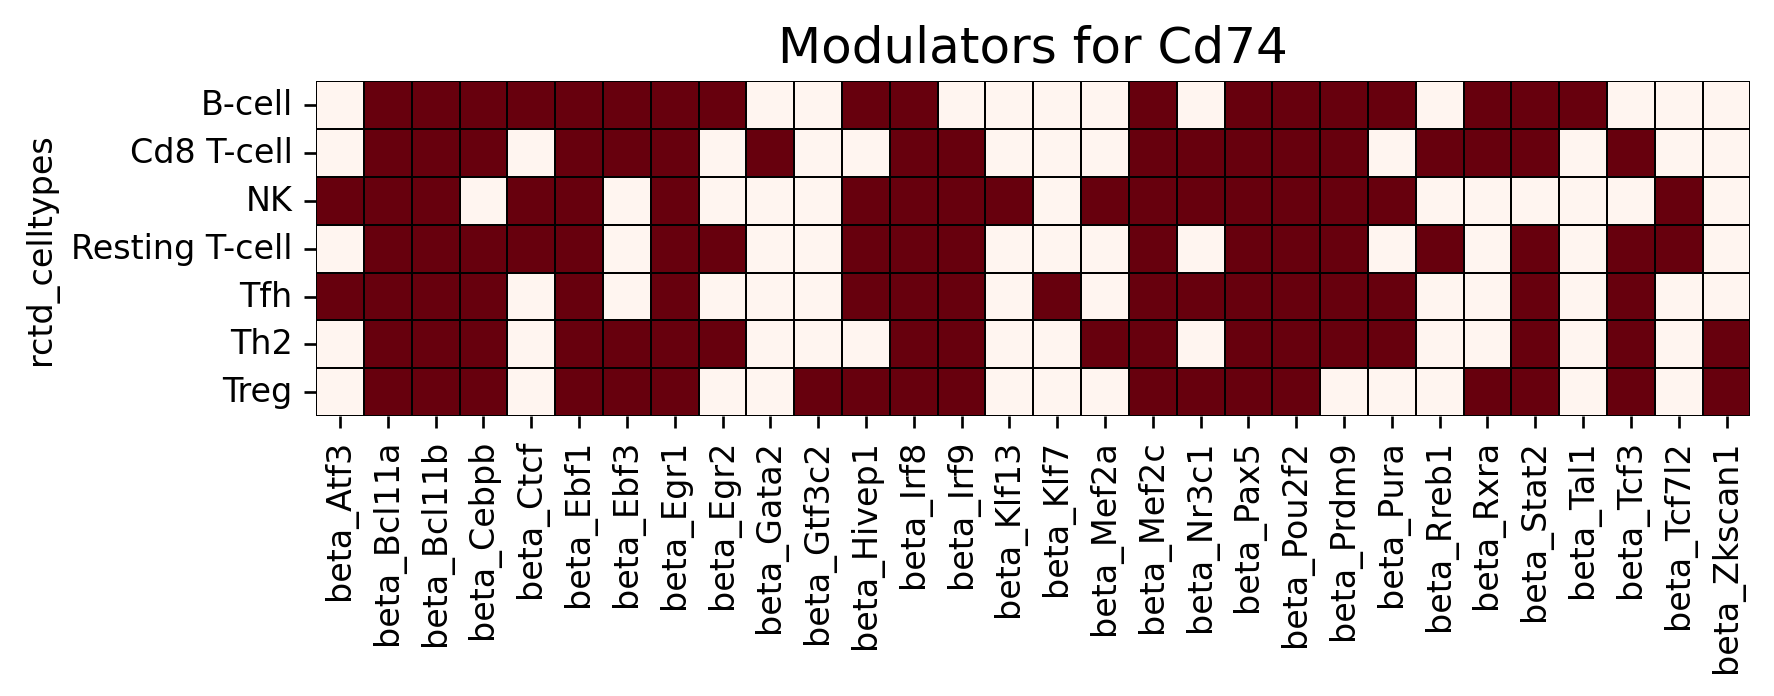

In [33]:
plt.rcParams['figure.figsize'] = (25, 3)
plt.rcParams['figure.dpi'] = 120

hmap = df[[
        'beta_'+i for i in estimator.modulators if '#' not in i and '$' not in i]+[
            'rctd_celltypes']].groupby('rctd_celltypes').mean().abs()>0
sns.heatmap(
    hmap.loc[:, (hmap.sum(0) > 0)],
    square=True,
    cbar=False,
    linewidths=0.5,
    linecolor='black',
    xticklabels=True,
    yticklabels=True,
    cmap='Reds'
)
plt.title(f'Modulators for {estimator.target_gene}', fontsize=15)
plt.tight_layout()
plt.show()

# plt.rcParams['figure.figsize'] = (25, 5)
# hmap = df[[
#         'beta_'+i for i in estimator.modulators if '$' in i]+[
#             'rctd_celltypes']].groupby('rctd_celltypes').mean().abs()>0
# sns.heatmap(
#     hmap.loc[:, (hmap.sum(0) > 0)],
#     square=True,
#     cbar=False,
#     linewidths=0.5,
#     linecolor='black',
#     xticklabels=True,
#     yticklabels=True,
#     cmap='Reds'
# )
# plt.title(f'Modulators for {estimator.target_gene}', fontsize=15)
# plt.tight_layout()
# plt.show()
# hmap = df[[
#         'beta_'+i for i in estimator.modulators if '#' in i]+[
#             'rctd_celltypes']].groupby('rctd_celltypes').mean().abs()>0
# sns.heatmap(
#     hmap.loc[:, (hmap.sum(0) > 0)],
#     square=True,
#     cbar=False,
#     linewidths=0.5,
#     linecolor='black',
#     xticklabels=True,
#     yticklabels=True,
#     cmap='Reds'
# )

# plt.title(f'Modulators for {estimator.target_gene}', fontsize=15)
# plt.tight_layout()
# plt.show()

In [18]:
y_pred = CellularNicheNetwork.predict_y(inputs_x, betas)

In [19]:
r2_score(
    estimator.train_df[estimator.target_gene], 
    y_pred.cpu().numpy()
)


0.9911950868612002

In [20]:
cmaps = dict(zip(range(7), ['rainbow', 'hot', 'cool_r', 'spring', 'viridis', 'PuRd', 'Reds']))


In [21]:
df[['beta0']+['beta_'+i for i in estimator.modulators]].mean().sort_values(ascending=False)[:30]

beta0                      0.205882
beta_Mef2c                 0.168317
beta_Ebf1                  0.143337
beta_Bcl11a                0.140762
beta_Pax5                  0.133816
beta_Irf8                  0.110635
beta_Prdm9                 0.046033
beta_Angptl4$Sdc4          0.043541
beta_Pou2f2                0.042761
beta_Tnfsf13b$Tnfrsf13c    0.040622
beta_C4b$Cr2               0.030787
beta_C3$Cr2                0.030317
beta_Cebpb                 0.029141
beta_Stat2                 0.024234
beta_Il4$Il4ra             0.020772
beta_Ebf3                  0.019166
beta_Csf1$Csf1r            0.017339
beta_Clcf1#Rxra            0.013781
beta_Lif#Mef2c             0.013130
beta_Il15#Mef2c            0.010044
beta_Il21#Mef2c            0.009434
beta_Igf1#Egr1             0.008496
beta_Ebi3#Rxra             0.008411
beta_Il21#Ebf1             0.008393
beta_Il21#Rxra             0.008211
beta_Irf9                  0.007987
beta_Il21#Ctcf             0.007670
beta_Il15#Ebf1             0

In [ ]:
# markers = ['o', 'X', '<', '^', 'v', 'D', '>']
# cmaps = dict(zip(range(7), ['rainbow', 'cool', 'RdYlGn_r', 'spring_r', '', 'PuRd', 'Reds']))
# cell_map = dict(zip(df['rctd_cluster'], df['rctd_celltypes']))

# def plot(plot_for, clusters=[0, 1, 2], with_expr=False, size=25, linewidth=0.5, alpha=1, edgecolor='black', dpi=100, figsize=(11, 9)):

#     fig, (ax, cax) = plt.subplots(1, 2, dpi=dpi, figsize=figsize, gridspec_kw={'width_ratios': [4, 0.5]})

#     for i in clusters:
#         betas_df = df[['beta0']+['beta_'+i for i in np.unique(estimator.modulators+estimator.ligands+estimator.receptors)]][df.rctd_cluster==i]
#         betas_df = betas_df.join(estimator.train_df)

#         if with_expr:
#             betas_df[plot_for] = betas_df[plot_for]*betas_df[plot_for.replace('beta_', '')]

#         sns.scatterplot(
#             data=betas_df.join(df[['x', 'y', 'rctd_celltypes']]),
#             x='x', 
#             y='y',
#             hue=plot_for,
#             palette=cmaps[i],
#             s=size,
#             # alpha=1 if i == 0 else 0.1,
#             alpha=alpha,
#             linewidth=linewidth,
#             edgecolor=edgecolor,
#             legend=False,
#             style='rctd_celltypes',
#             markers=markers,
#             ax=ax
#         )
#     ax.axis('off')

#     norm = None

#     cbar_width = 0.15  # Width of each colorbar
#     cbar_height = 0.8 / len(cmaps)  # Height of each colorbar
#     for i, cmap_name in cmaps.items():
#         if i not in [0, 1, 2]:
#             continue
#         cmap = plt.get_cmap(cmap_name)
#         sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
#         sm.set_array([])
#         cax_i = cax.inset_axes([0.2, 0.95 - (i+1)*cbar_height*2.5, cbar_width, cbar_height*1.5])
#         cbar = fig.colorbar(sm, cax=cax_i, orientation='vertical')
#         cbar.ax.tick_params(labelsize=9)  # Reduce tick label size
#         cbar.ax.set_title(f'{cell_map[i]}', fontsize=12, pad=8)  # Reduce title size and padding

#     cax.set_ylabel(plot_for, fontsize=8)
#     cax.axis('off')

#     unique_styles = sorted(set(df['rctd_celltypes']))
#     style_handles = [plt.Line2D([0], [0], marker=m, color='w', markerfacecolor='gray', 
#                     markersize=10, linestyle='None', alpha=1) 
#                     for m in markers][:len(unique_styles)]
#     ax.legend(style_handles, unique_styles, ncol=1,
#         title='Cell types', loc='upper left', 
#         frameon=False)

#     ax.set_title(f'{plot_for} > {estimator.target_gene}', fontsize=15)
    
#     return ax

In [22]:
markers = ['o', 'X', '<', '^', 'v', 'D', '>']
cmaps = dict(zip(range(7), ['rainbow', 'cool', 'RdYlGn_r', 'spring_r', '', 'PuRd', 'Reds']))
cell_map = dict(zip(df['rctd_cluster'], df['rctd_celltypes']))

def plot(plot_for, clusters=[0, 1, 2], with_expr=False, size=25, linewidth=0.5, alpha=1, edgecolor='black', dpi=100, figsize=(11, 9), fig=None, axes=None):

    if fig is None or axes is None:
        fig, (ax, cax) = plt.subplots(1, 2, dpi=dpi, figsize=figsize, gridspec_kw={'width_ratios': [4, 0.5]})
    else:
        ax, cax = axes

    for i in clusters:
        betas_df = df[df.rctd_cluster==i]
        missing_columns = list(set(estimator.train_df.columns) - set(betas_df.columns))
        betas_df = betas_df.join(estimator.train_df[missing_columns])

        if with_expr:
            betas_df[plot_for] = betas_df[plot_for]*betas_df[plot_for.replace('beta_', '')]

        sns.scatterplot(
            data=betas_df,
            x='x', 
            y='y',
            hue=plot_for,
            palette=cmaps[i],
            s=size,
            # alpha=1 if i == 0 else 0.1,
            alpha=alpha,
            linewidth=linewidth,
            edgecolor=edgecolor,
            legend=False,
            style='rctd_celltypes',
            markers=markers,
            ax=ax
        )
    ax.axis('off')

    norm = None

    cbar_width = 0.15  # Width of each colorbar
    cbar_height = 0.8 / len(cmaps)  # Height of each colorbar
    for i, cmap_name in cmaps.items():
        if i not in [0, 1, 2]:
            continue
        cmap = plt.get_cmap(cmap_name)
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        cax_i = cax.inset_axes([0.2, 0.95 - (i+1)*cbar_height*2.5, cbar_width, cbar_height*1.5])
        cbar = fig.colorbar(sm, cax=cax_i, orientation='vertical')
        cbar.ax.tick_params(labelsize=9)  # Reduce tick label size
        cbar.ax.set_title(f'{cell_map[i]}', fontsize=12, pad=8)  # Reduce title size and padding

    cax.set_ylabel(plot_for, fontsize=8)
    cax.axis('off')

    unique_styles = sorted(set(df['rctd_celltypes']))
    style_handles = [plt.Line2D([0], [0], marker=m, color='w', markerfacecolor='gray', 
                    markersize=10, linestyle='None', alpha=1) 
                    for m in markers][:len(unique_styles)]
    ax.legend(style_handles, unique_styles, ncol=1,
        title='Cell types', loc='lower left',  
        frameon=False)

    ax.set_title(f'{plot_for} > {estimator.target_gene}', fontsize=15)
    
    return ax

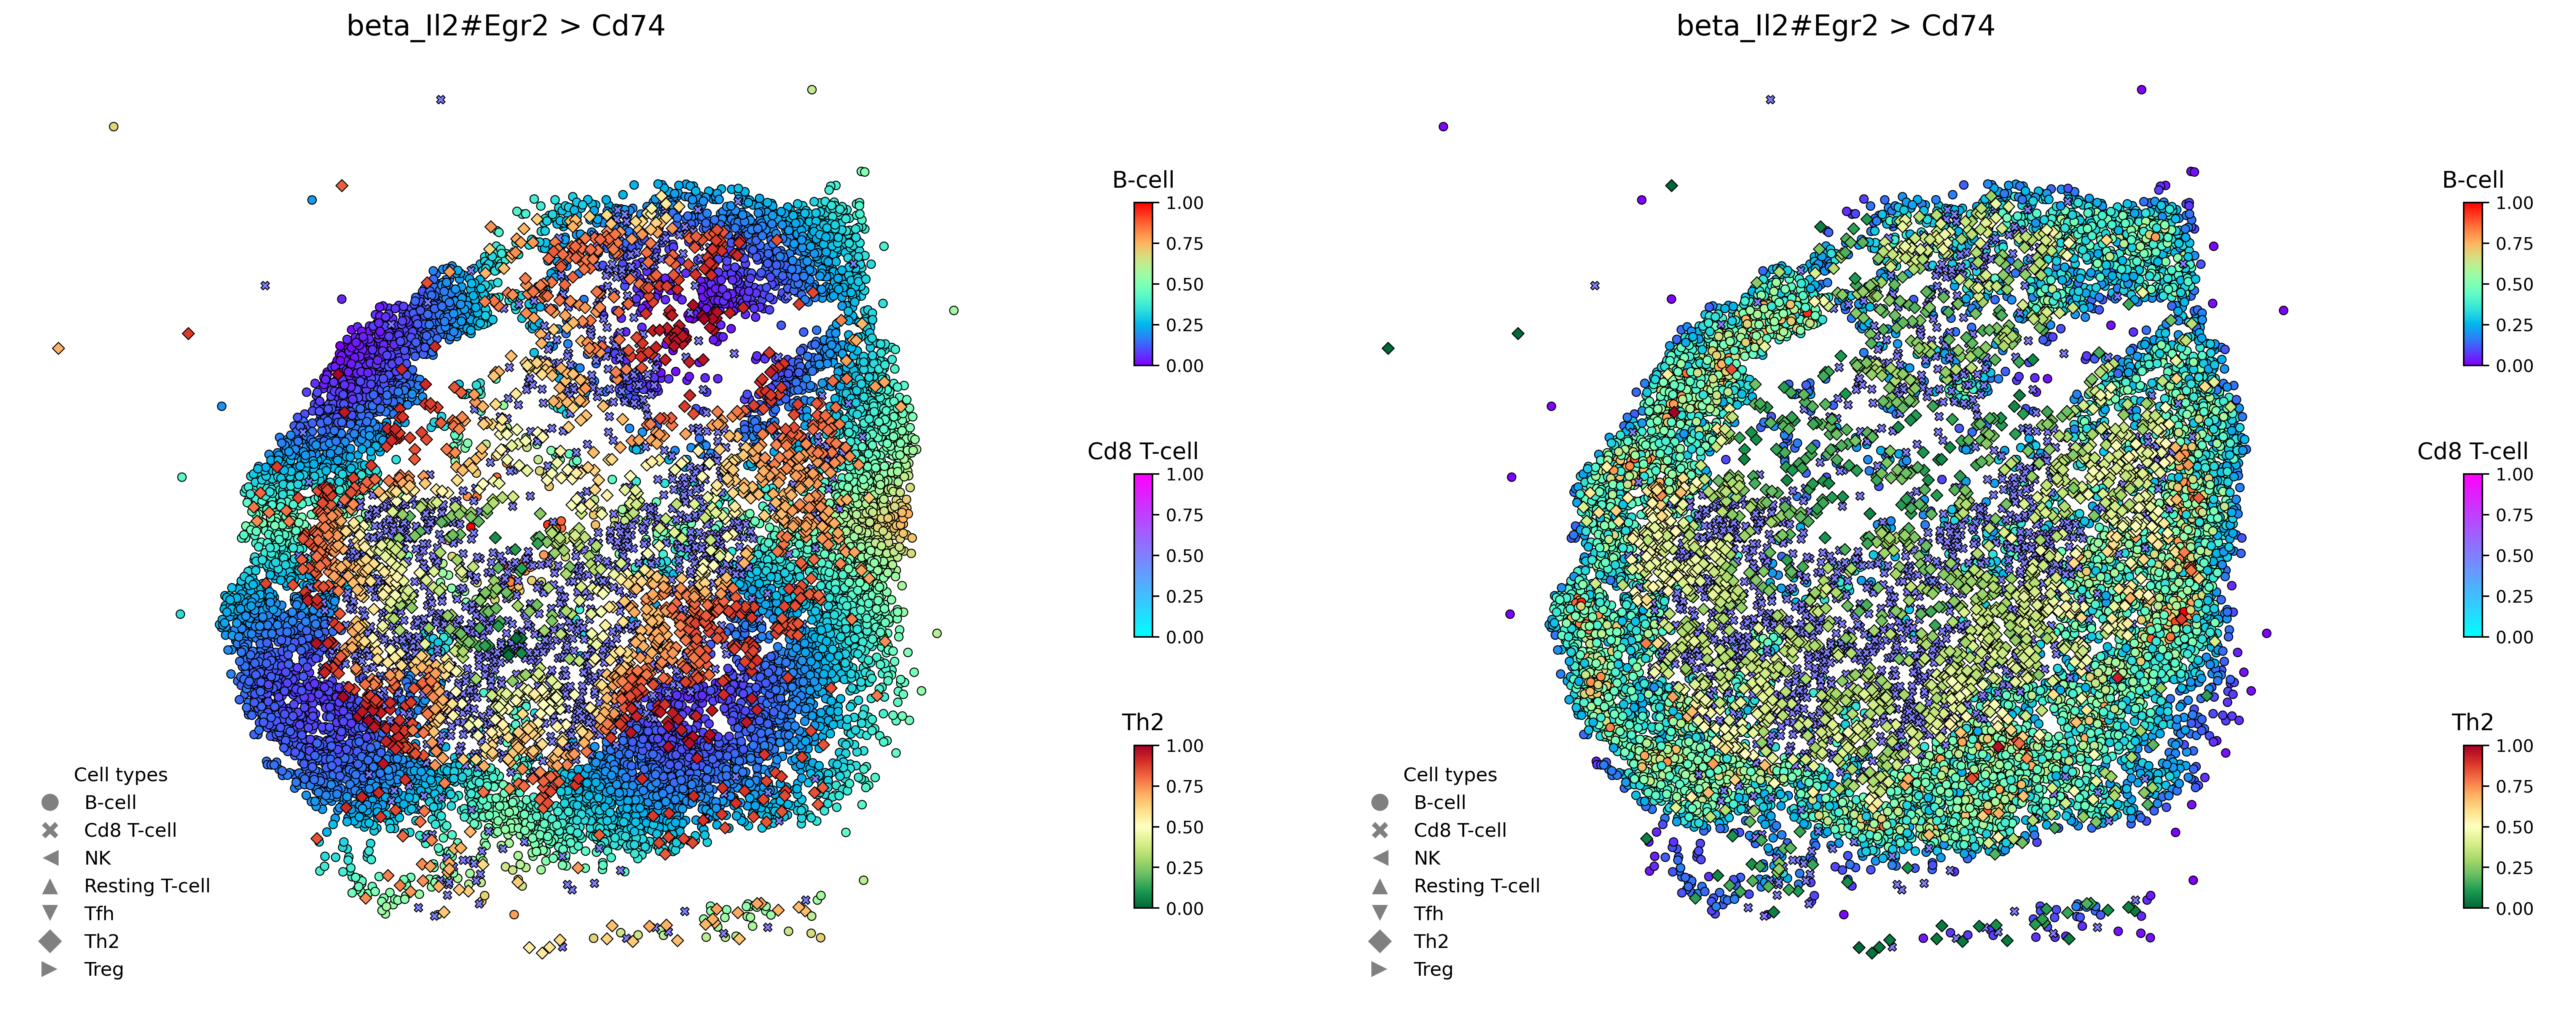

In [24]:
fig, axs = plt.subplots(1, 4, dpi=180, figsize=(12*2, 9*1), gridspec_kw={'width_ratios': [4, 0.5]*2})
axs = axs.flatten()
axs = [(axs[i], axs[i+1]) for i in range(0, len(axs), 2)]
plot('beta_Il2#Egr2', dpi=100, size=20, fig=fig, axes=axs[0])
plot('beta_Il2#Egr2', dpi=100, size=20, fig=fig, axes=axs[1], with_expr=True)
# plot('Egr2', dpi=100, size=20, fig=fig, axes=axs[2])
# plot('Il2', dpi=100, size=20, fig=fig, axes=axs[3])
# plot('beta_Egr2', dpi=100, size=20, fig=fig, axes=axs[4])
# plot('Il2#Egr2', dpi=100, size=20, fig=fig, axes=axs[5])
plt.show()
